In [23]:
%load_ext autoreload
%autoreload 2

import os
import sys

%store -r DISCO_ROOT_FOLDER
if "DISCO_ROOT_FOLDER" in globals():
    os.chdir(DISCO_ROOT_FOLDER)
    sys.path.append(DISCO_ROOT_FOLDER)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Synth Noise - Good vs Bad Noise

In [25]:
# Good Noise

import numpy as np
from src.utils.data import add_noise

def make_blob_and_noise_dist_uniform(n_samples, n_noise=0, seed=0):
    np.random.seed(seed)
    n_samples = n_samples
    centers = np.array([[-20, -20], [20, -20], [-20, 20], [20, 20]])
    X = np.empty((0, 2))
    l = np.empty((0))
    for i, center in enumerate(centers):
        X_i = np.empty((0, 2))
        while len(X_i) < n_samples:
            X_i_ = np.random.uniform(low=center - 2, high=center + 2, size=(n_samples * 10, 2))
            X_i_mask = np.linalg.norm(X_i_ - center, axis=1) <= 2
            X_i_ = X_i_[X_i_mask]
            X_i = np.vstack((X_i, X_i_[: min(n_samples - len(X_i), len(X_i_))]))
        X = np.vstack((X, X_i))
        l = np.hstack((l, np.array([i] * len(X_i))))
    X, l = add_noise(X, l, n_noise, 2, 0.5, border=5 + 2 * (n_noise / n_samples) * (np.max(X) - np.min(X)))
    return X, l


np.random.seed(0)
random_seeds = np.random.choice(1_000_000, replace=False, size=10)
noises = np.arange(0, 801, 80)
good_synth_noise_datasets = [
    [make_blob_and_noise_dist_uniform(200, n_noise=n_noise, seed=seed) for seed in random_seeds] for n_noise in noises
]

In [ ]:
import matplotlib.pyplot as plt

X = good_synth_noise_datasets[10][0][0]
l = good_synth_noise_datasets[10][0][1]

np.random.seed(0)
X_, l_ = add_noise(X, l, 10000, 10, 0.05)

plt.figure()
# plt.scatter(X_[:, 0][l_ == -1], X_[:, 1][l_ == -1], c="red", s=130, alpha=0.8, marker="+")
plt.scatter(X_[:, 0][l_ != -1], X_[:, 1][l_ != -1], c=l_[l_ != -1], s=3000)

plt.gca().set_xticks([])
plt.gca().set_yticks([])

# xlim = plt.gca().get_xlim()
# ylim = plt.gca().get_ylim()

plt.gca().set_xlim(map(lambda x: x * 2, xlim))
plt.gca().set_ylim(map(lambda x: x * 2, ylim))

plt.tight_layout()
plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.savefig("imgs/good_no_noise.png", format="png", bbox_inches="tight", pad_inches=0.01)
plt.show()

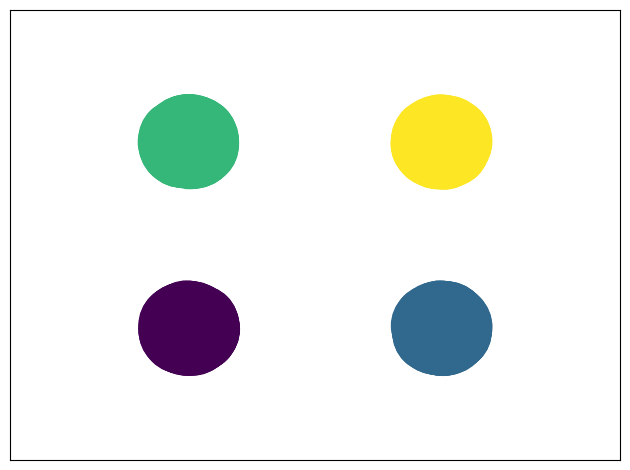

In [94]:
import matplotlib.pyplot as plt

X = good_synth_noise_datasets[10][0][0]
l = good_synth_noise_datasets[10][0][1]

np.random.seed(0)
X_, l_ = add_noise(X, l, 10000, 10, 0.05)

plt.figure()
plt.scatter(X_[:, 0][l_ == -1], X_[:, 1][l_ == -1], c="red", s=130, alpha=0.8, marker="+")
plt.scatter(X_[:, 0][l_ != -1], X_[:, 1][l_ != -1], c=l_[l_ != -1], s=3000)

plt.gca().set_xticks([])
plt.gca().set_yticks([])

# xlim = plt.gca().get_xlim()
# ylim = plt.gca().get_ylim()

plt.gca().set_xlim(map(lambda x: x * 2, xlim))
plt.gca().set_ylim(map(lambda x: x * 2, ylim))

plt.tight_layout()
plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.savefig("imgs/good_noise.png", format="png", bbox_inches="tight", pad_inches=0.01)
plt.show()

In [48]:

from sklearn.neighbors import NearestNeighbors

def assign_nn(X_, l_):
    if len(l_[l_==-1]) == 0:
        return l_
    nn = NearestNeighbors()
    nn.fit(X_[l_ != -1])

    neighb = nn.kneighbors(X_[l_ == -1], 1)
    l__ =l_.copy()
    l__[l_ == -1] = l_[neighb[1].reshape(-1)]
    return l__

In [49]:
good_synth_noise_datasets2 = [
    [(X, assign_nn(X, l)) for X, l in datasets] for datasets in good_synth_noise_datasets
]

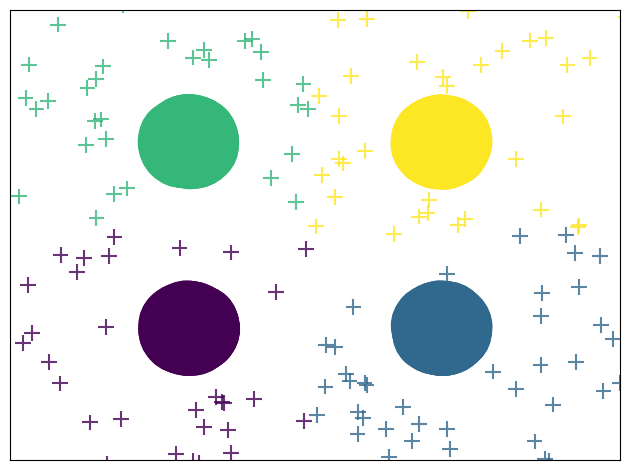

In [93]:
import matplotlib.pyplot as plt

X = good_synth_noise_datasets[10][0][0]
l = good_synth_noise_datasets[10][0][1]

np.random.seed(0)
X_, l_ = add_noise(X, l, 10000, 10, 0.05)

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors()
nn.fit(X_[l_ != -1])

neighb = nn.kneighbors(X_[l_ == -1], 1)
l__ = l_.copy()
l__[l_ == -1] = l_[neighb[1].reshape(-1)]
l__

plt.figure()
plt.scatter(X_[:, 0][l_ != -1], X_[:, 1][l_ != -1], c=l_[l_ != -1], s=3000)
plt.scatter(X_[:, 0][l_ == -1], X_[:, 1][l_ == -1], c=l__[l_ == -1], s=130, alpha=0.8, marker="+")

plt.gca().set_xticks([])
plt.gca().set_yticks([])

# xlim = plt.gca().get_xlim()
# ylim = plt.gca().get_ylim()

plt.gca().set_xlim(map(lambda x: x * 2, xlim))
plt.gca().set_ylim(map(lambda x: x * 2, ylim))

plt.tight_layout()
plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.savefig("imgs/good_noise2.png", format="png", bbox_inches="tight", pad_inches=0.01)
plt.show()

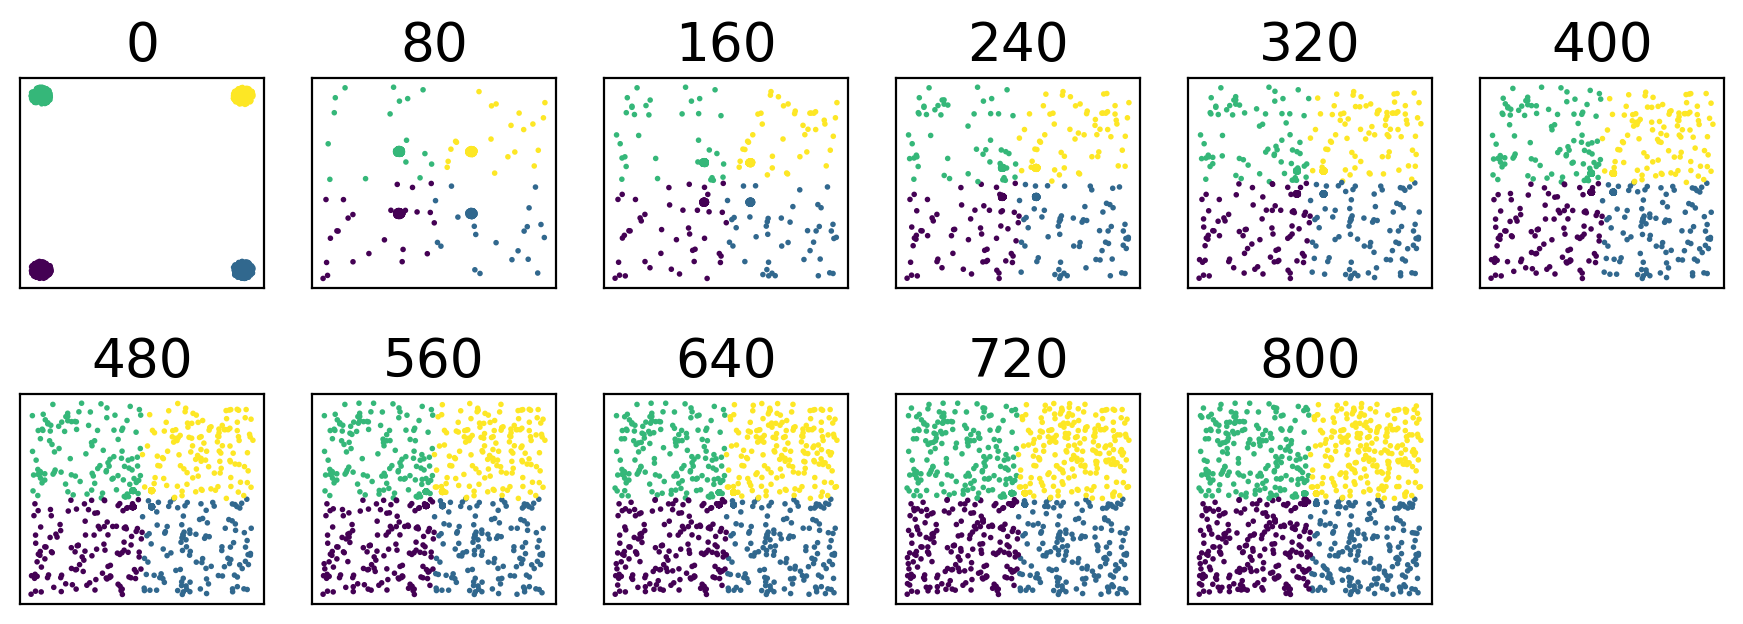

In [236]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_datasets
from src.utils.data import sample_datasets


fig = plot_datasets(good_synth_noise_datasets2, noises, n_cols=6, figsize=1.5)

# axes = fig.get_axes()
# for ax in axes:
#     ax.set_ylim(-20, 20)
#     ax.set_xlim(-20, 20)
#     ax.set_aspect("equal", adjustable="datalim")

# plt.savefig("imgs/good_noise_data2.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

In [237]:
from src.utils.experiments import cache, calc_eval_measures_for_multiple_datasets
from src.utils.metrics import create_and_rescale_df, SELECTED_METRICS, create_and_filter_df


eval_results = cache(
    "good_synth_noise2",
    calc_eval_measures_for_multiple_datasets,
    [good_synth_noise_datasets2, noises],
    recalc=False,
)

# selected_metrics = ["DISCO", "DBCV", "LCCV", "CVNN"]

df = create_and_rescale_df(eval_results)
df_ = create_and_filter_df(eval_results)

In [242]:
import pandas as pd

df_no_noise = pd.DataFrame(df_.loc[df_.dataset == 0].groupby(["measure"])["value"].mean()).reindex(SELECTED_METRICS).rename(columns={"value": "no noise"})
df_good_noise = pd.DataFrame(df_.loc[df_.dataset == 640].groupby(["measure"])["value"].mean()).reindex(SELECTED_METRICS).rename(columns={"value": "noise"})
df_merged = df_no_noise.merge(df_good_noise, left_index=True, right_index=True)
metric_order = ["DISCO", "SILHOUETTE", "S_DBW", "CVNN", "DBCV", "DCSI", "LCCV", "VIASCKDE", "CVDD", "CDBW"]
df_merged = df_merged.reindex(index=metric_order)
df_merged.round(2)

,no noise,noise
measure,,
DISCO,0.99,0.25
SILHOUETTE,0.95,0.24
S_DBW,0.05,0.80
CVNN,7.62,559.27
DBCV,1.00,-0.83
DCSI,1.00,1.00
LCCV,0.62,0.43
VIASCKDE,0.20,0.11
CVDD,7981.55,0.01


[Text(0, 0, '0'),
 Text(80, 0, '10'),
 Text(160, 0, '20'),
 Text(240, 0, '30'),
 Text(320, 0, '40'),
 Text(400, 0, '50'),
 Text(480, 0, '60'),
 Text(560, 0, '70'),
 Text(640, 0, '80'),
 Text(720, 0, '90'),
 Text(800, 0, '100')]

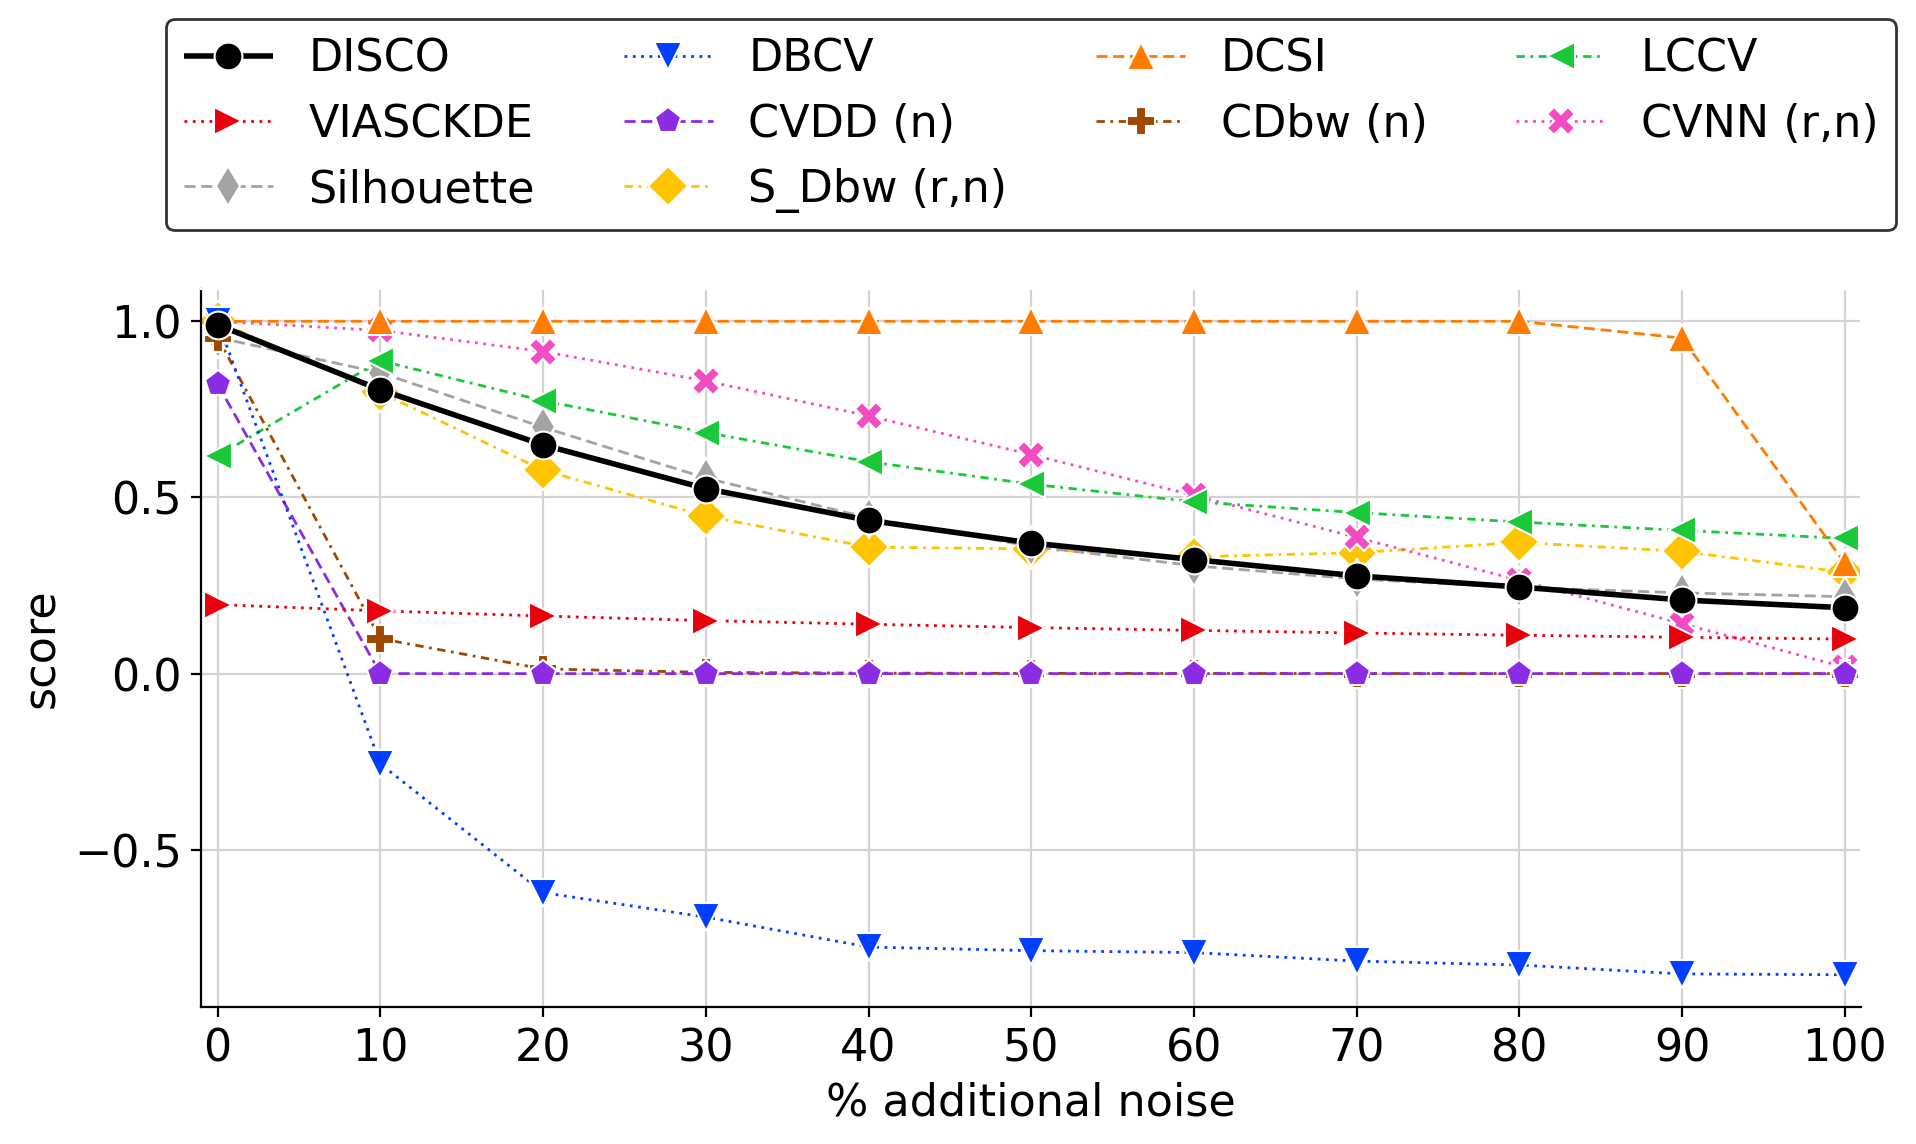

In [241]:
from src.utils.plots import plot_lineplot, GRAY
import seaborn as sns

eps = 8
x_range = noises[0] - eps, noises[-1] + eps

fig = plot_lineplot(
    df,
    "dataset",
    "value",
    "measure",
    x_label="% additional noise",
    y_label="score",
    x_range=x_range,
    y_range=(None, None),
    # figsize=(10, 4),
    # palette=["black"] + list(np.array(sns.color_palette("bright"))[[0, 2, 6]]) + [GRAY],
    # markers=["o"] + list(np.array(["v", "^", "<", ">", "p", "P", "X", "d", "D", "H"])[[0, 2, 6]]),
    # dashes=[(1, 0)] + list(np.array([(1, 2), (4, 2), (3, 2, 1, 2)], dtype=object)[[0, 2, (6 % 3)]]),
    # sizes=[3] + [2] * 10,
    errorbar=None,
    markersize=10,
)
ax = fig.gca()
ax.set_xticks(noises)
ax.set_xticklabels(np.arange(0, 101, 10))
# plt.savefig("imgs/good_synth_noise.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

In [34]:
# Bad Noise

import numpy as np
from src.utils.data import add_noise

def make_blob_and_noise_dist_uniform(n_samples, n_noise=0, seed=0):
    np.random.seed(seed)
    n_samples = n_samples
    centers = np.array([[-20, -20], [20, -20], [-20, 20], [20, 20]])
    X = np.empty((0, 2))
    l = np.empty((0))
    for i, center in enumerate(centers):
        X_i = np.empty((0, 2))
        while len(X_i) < n_samples:
            X_i_ = np.random.uniform(low=center - 2, high=center + 2, size=(n_samples * 10, 2))
            X_i_mask = np.linalg.norm(X_i_ - center, axis=1) <= 2
            X_i_ = X_i_[X_i_mask]
            X_i = np.vstack((X_i, X_i_[: min(n_samples - len(X_i), len(X_i_))]))
        X = np.vstack((X, X_i))
        l = np.hstack((l, np.array([i] * len(X_i))))
    n_noise = n_noise // len(centers)
    for i, center in enumerate(centers):
        X_i = np.empty((0, 2))
        while len(X_i) < n_noise:
            X_i_ = np.random.uniform(low=center - 2, high=center + 2, size=(n_noise * 10, 2))
            X_i_mask = np.linalg.norm(X_i_ - center, axis=1) <= 2
            X_i_ = X_i_[X_i_mask]
            X_i = np.vstack((X_i, X_i_[: min(n_noise - len(X_i), len(X_i_))]))
        X = np.vstack((X, X_i))
        l = np.hstack((l, np.array([-1] * len(X_i))))
    return X, l


np.random.seed(0)
random_seeds = np.random.choice(1_000_000, replace=False, size=10)
noises = np.arange(0, 801, 80)
bad_synth_noise_datasets = [
    [make_blob_and_noise_dist_uniform(200, n_noise=n_noise, seed=seed) for seed in random_seeds] for n_noise in noises
]

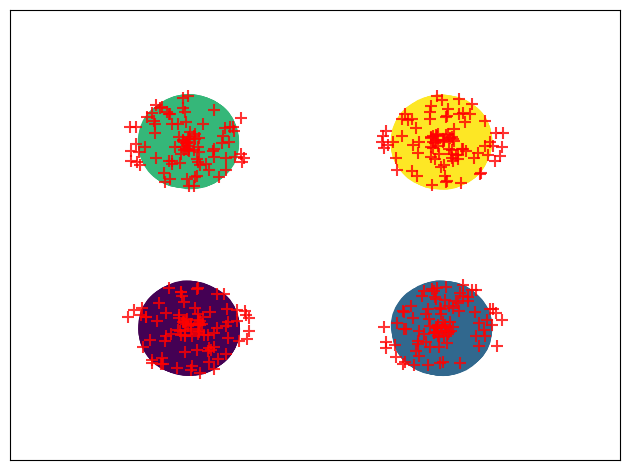

In [75]:
import matplotlib.pyplot as plt

X = bad_synth_noise_datasets[1][0][0]
l = bad_synth_noise_datasets[1][0][1]

np.random.seed(0)
X_, l_ = add_noise(X, l, 0, 9, 0.05)

n_noise=70
for i, center in enumerate(np.array([[-20, -20], [20, -20], [-20, 20], [20, 20]])):
    X_i = np.empty((0, 2))
    while len(X_i) < n_noise:
        radius = 10
        X_i_ = np.random.uniform(low=center - radius, high=center + radius, size=(n_noise * 10, 2))
        X_i_mask = np.linalg.norm(X_i_ - center, axis=1) <= radius
        X_i_ = X_i_[X_i_mask]
        X_i = np.vstack((X_i, X_i_[: min(n_noise - len(X_i), len(X_i_))]))
    X_ = np.vstack((X_, X_i))
    l_ = np.hstack((l_, np.array([-1] * len(X_i))))

plt.figure()
plt.scatter(X_[:, 0][l_ != -1], X_[:, 1][l_ != -1], c=l_[l_ != -1], s=3000)
plt.scatter(X_[:, 0][l_ == -1], X_[:, 1][l_ == -1], c="red", s=80, alpha=0.8, marker="+")

plt.gca().set_xticks([])
plt.gca().set_yticks([])

# xlim = plt.gca().get_xlim()
# ylim = plt.gca().get_ylim()

plt.gca().set_xlim(map(lambda x: x * 2, xlim))
plt.gca().set_ylim(map(lambda x: x * 2, ylim))

plt.tight_layout()
plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.savefig("imgs/bad_noise.png", format="png", bbox_inches="tight", pad_inches=0.01)
plt.show()

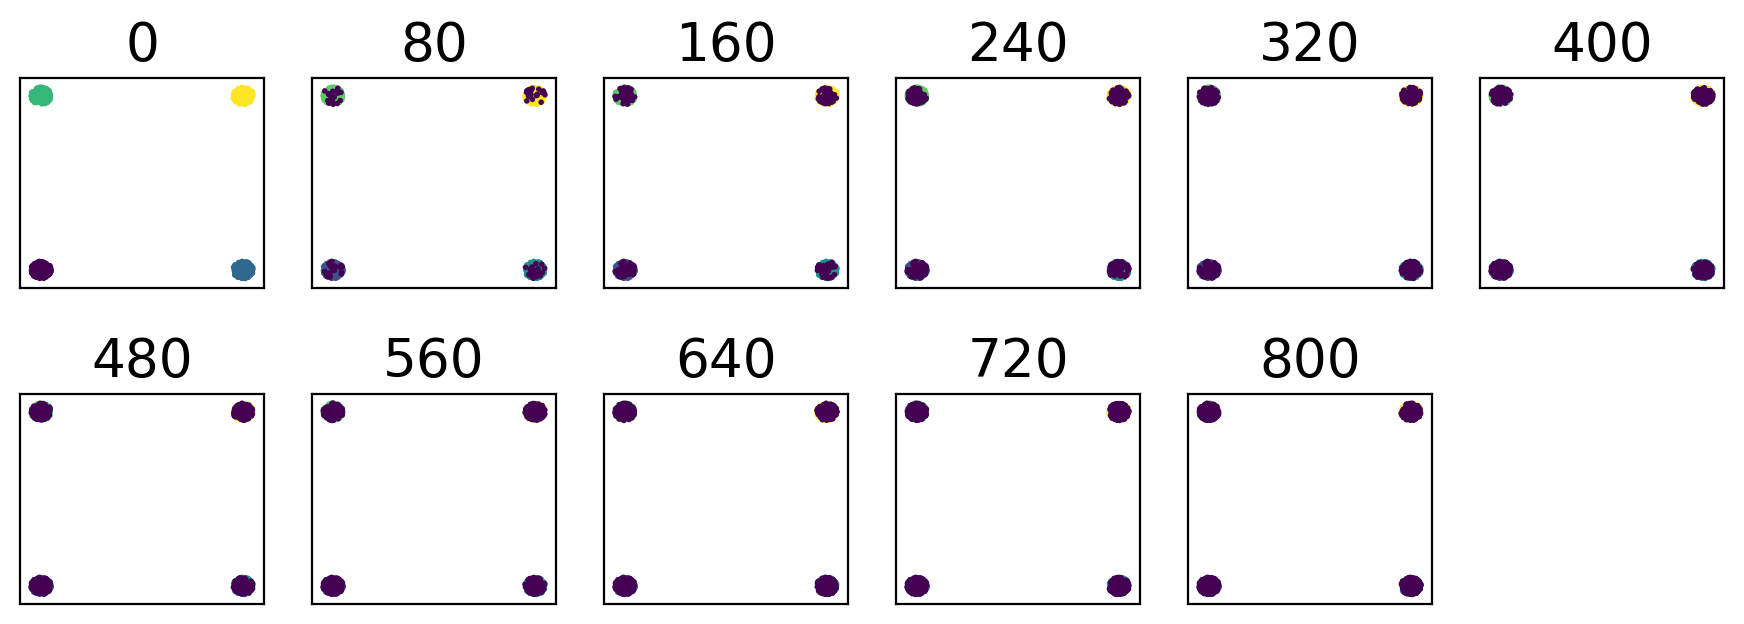

In [8]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_datasets
from src.utils.data import sample_datasets


fig = plot_datasets(bad_synth_noise_datasets, noises, n_cols=6, figsize=1.5)

# axes = fig.get_axes()
# for ax in axes:
#     ax.set_ylim(-20, 20)
#     ax.set_xlim(-20, 20)
#     ax.set_aspect("equal", adjustable="datalim")

plt.savefig("imgs/bad_noise_data.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

In [77]:
from src.utils.experiments import cache, calc_eval_measures_for_multiple_datasets
from src.utils.metrics import create_and_rescale_df, SELECTED_METRICS, create_and_filter_df


eval_results = cache(
    "bad_synth_noise",
    calc_eval_measures_for_multiple_datasets,
    [bad_synth_noise_datasets, noises],
    recalc=False,
)

# selected_metrics = ["DISCO", "DBCV", "LCCV", "CVNN"]

df = create_and_rescale_df(eval_results)
df = create_and_filter_df(eval_results)

In [78]:
import pandas as pd

df_no_noise = pd.DataFrame(df.loc[df.dataset == 0].groupby(["measure"])["value"].mean()).reindex(SELECTED_METRICS).rename(columns={"value": "no noise"})
df_bad_noise = pd.DataFrame(df.loc[df.dataset == 800].groupby(["measure"])["value"].mean()).reindex(SELECTED_METRICS).rename(columns={"value": "noise"})
df_merged = df_no_noise.merge(df_bad_noise, left_index=True, right_index=True)
metric_order = ["DISCO", "SILHOUETTE", "S_DBW", "CVNN", "DBCV", "DCSI", "LCCV", "VIASCKDE", "CVDD", "CDBW"]
df_merged = df_merged.reindex(index=metric_order)
df_merged.round(2)

,no noise,noise
measure,,
DISCO,0.99,0.23
SILHOUETTE,0.95,-0.00
S_DBW,0.05,0.05
CVNN,7.62,7.41
DBCV,1.00,0.50
DCSI,1.00,1.00
LCCV,0.62,0.27
VIASCKDE,0.20,-0.00
CVDD,7981.55,7442.46


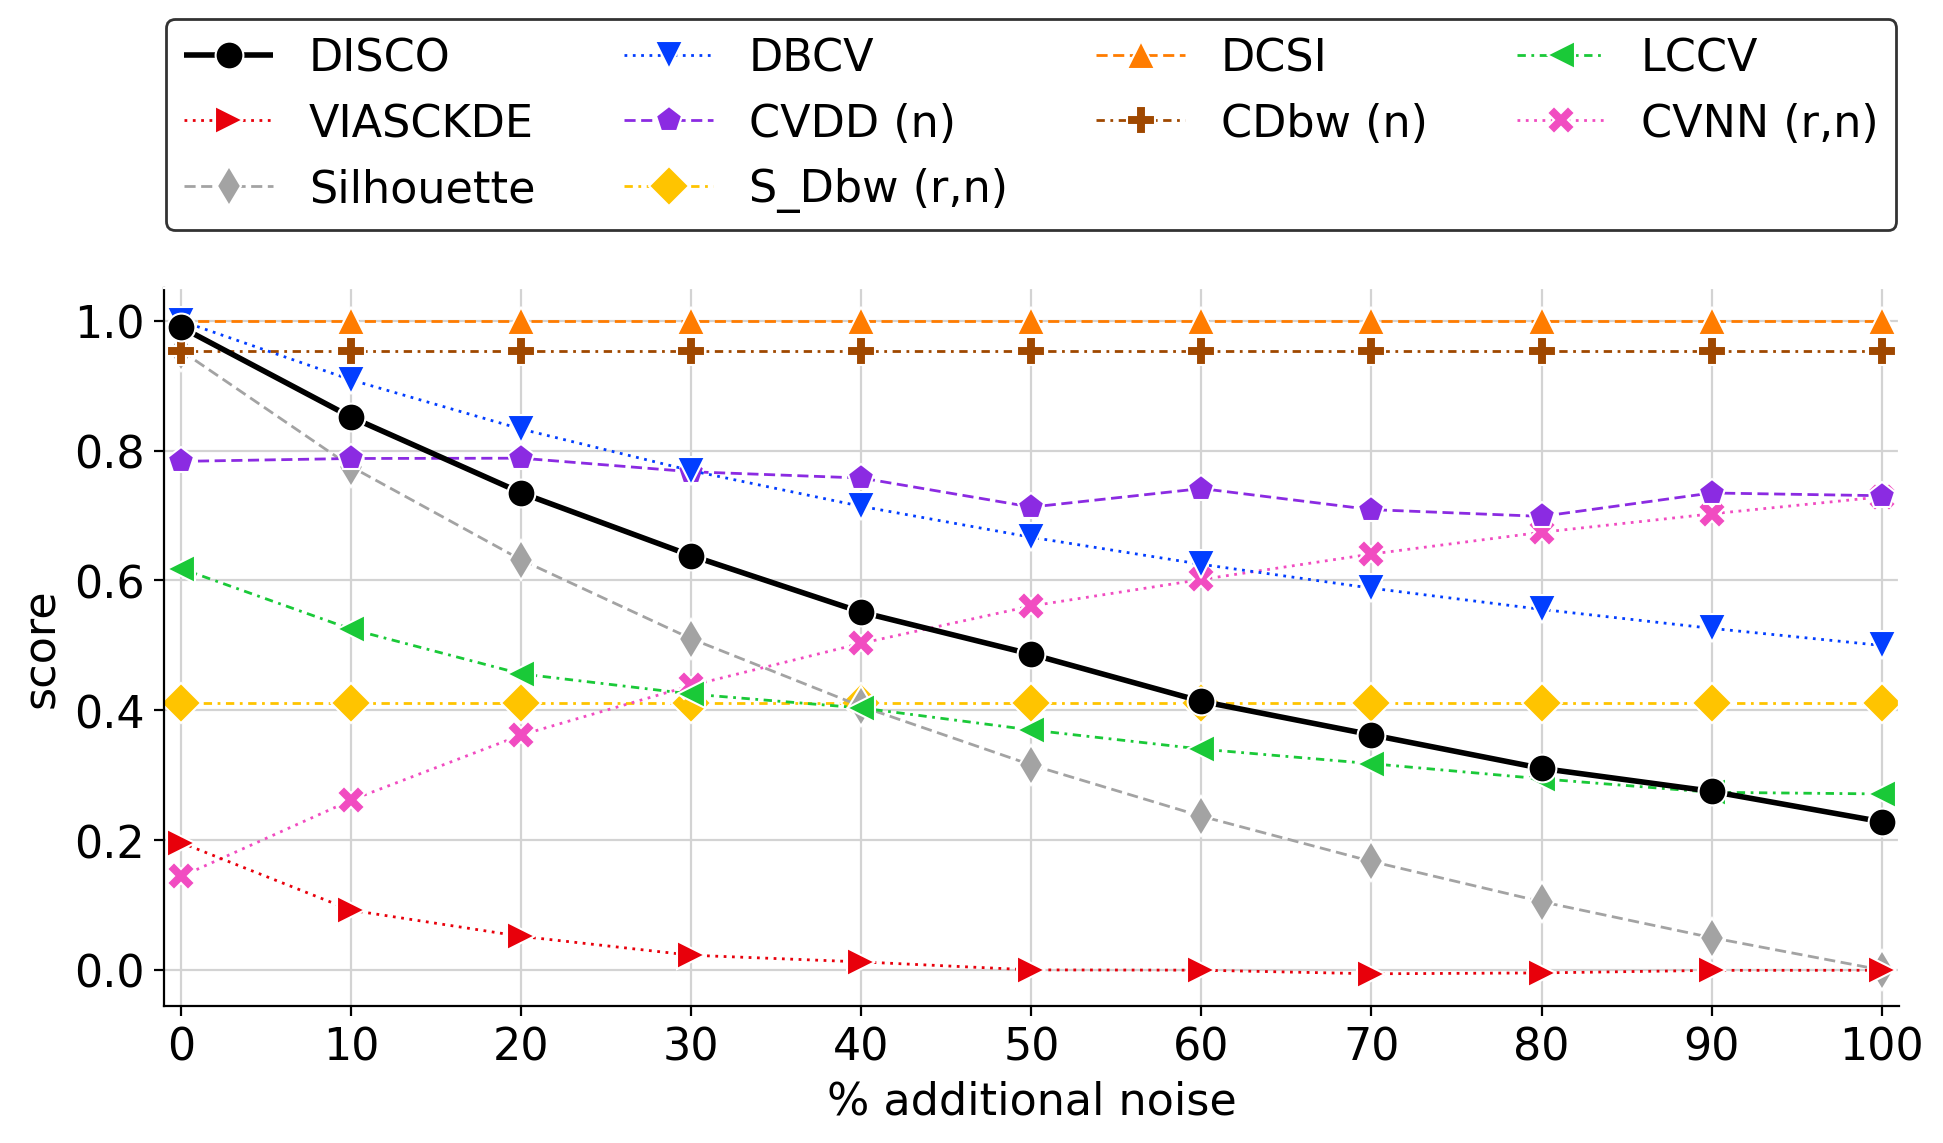

In [10]:
from src.utils.plots import plot_lineplot, GRAY
import seaborn as sns

eps = 8
x_range = noises[0] - eps, noises[-1] + eps

fig = plot_lineplot(
    df,
    "dataset",
    "value",
    "measure",
    x_label="% additional noise",
    y_label="score",
    x_range=x_range,
    y_range=(None, None),
    # figsize=(10, 4),
    # palette=["black"] + list(np.array(sns.color_palette("bright"))[[0, 2, 6]]) + [GRAY],
    # markers=["o"] + list(np.array(["v", "^", "<", ">", "p", "P", "X", "d", "D", "H"])[[0, 2, 6]]),
    # dashes=[(1, 0)] + list(np.array([(1, 2), (4, 2), (3, 2, 1, 2)], dtype=object)[[0, 2, (6 % 3)]]),
    # sizes=[3] + [2] * 10,
    errorbar=None,
    markersize=10,
)
ax = fig.gca()
ax.set_xticks(noises)
ax.set_xticklabels(np.arange(0, 101, 10))
plt.savefig("imgs/bad_synth_noise.pdf", format="pdf", bbox_inches="tight", pad_inches=0)